Text(0.5, 1.0, 'Failure Count for Different Orthonormalization Algorithms')

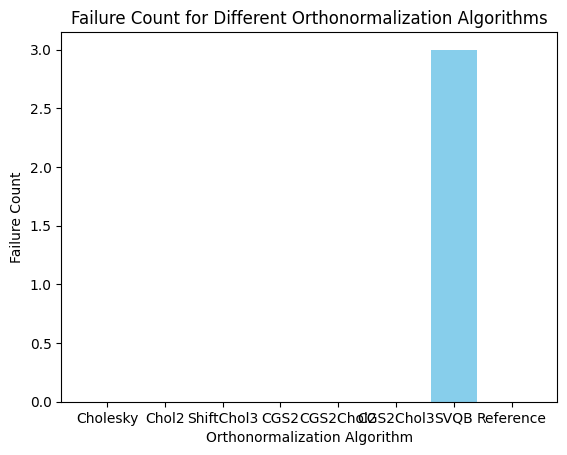

In [ ]:
import numpy as np
import batchlas

def generate_ill_conditioned_batch_fortran(m, n, B, kappa, mode="exact", rng=None, float_type=np.float32):
    """
    Generate a batch of B tall-skinny (m x n) matrices with condition number κ,
    stored in Fortran-contiguous order (shape = (m, n, B)).

    Args:
        m:     Number of rows (m > n)
        n:     Number of columns
        B:     Batch size
        kappa: Target condition number (sigma_max / sigma_min)
        mode:  "exact" (sigma_min = 1/κ) or "log" (logarithmic singular value decay)
        rng:   Optional NumPy random number generator (for reproducibility)
        float_type: Data type for the matrices (default: np.float32)

    Returns:
        A_batch: (m, n, B) Fortran-contiguous array of ill-conditioned matrices
    """
    if rng is None:
        rng = np.random.default_rng ()  # Use default RNG if none provided
    
    # Generate singular values based on mode
    s = np.ones(n, dtype=float_type)  # Initialize singular values
    if mode == "exact":
        s[-1] = 1 / kappa
    elif mode == "log":
        s = np.logspace(0, np.log10(1/kappa), n, base=10, dtype=float_type)
    else:
        raise ValueError("mode must be 'exact' or 'log'")
    
    D = np.diag(s)  # Create diagonal matrix of singular values
    
    # Preallocate Fortran-contiguous array (column-major, batch as last axis)
    A_batch = np.empty((m, n, B), order='F', dtype=float_type)
    
    for i in range(B):
        # Generate random orthogonal U (m x n) via QR decomposition
        U, _ = np.linalg.qr(rng.standard_normal((m, n)), mode='reduced')
        
        # Generate random orthogonal V (n x n)
        V, _ = np.linalg.qr(rng.standard_normal((n, n)), mode='reduced')
        
        # Compute A_i = U @ D @ V.T and store in Fortran order
        A_i = U @ D @ V.T
        
        # Ensure column-major layout for the matrix slice
        A_batch[..., i] = np.asfortranarray(A_i, dtype=float_type)

    return A_batch

queue = batchlas.Queue(batchlas.Device("gpu"))
a = generate_ill_conditioned_batch_fortran(512, 20 , 1024, 1e2, mode="exact", rng=np.random.default_rng(42), float_type=np.float32)

import matplotlib.pyplot as plt
# Define different orthonormalization algorithms to test
algorithms = [
    batchlas.OrthoAlgorithm.Cholesky,
    batchlas.OrthoAlgorithm.Chol2,
    batchlas.OrthoAlgorithm.ShiftChol3,
    batchlas.OrthoAlgorithm.CGS2,
    batchlas.OrthoAlgorithm.SVQB
]

# Store failure counts for each algorithm
failures = []

for algo in algorithms:
    # Copy the entire batch to avoid in-place modification
    batch_copy = a.copy(order='F')
    
    # Perform orthonormalization on the entire batch
    batchlas.ortho(queue, batch_copy, algo, batchlas.Backend.CUDA)
    
    # Measure orthonormality for each matrix in the batch
    failure_count = 0
    for i in range(batch_copy.shape[2]):  # Iterate over each matrix in the batch
        matrix = batch_copy[:, :, i]
        # Check orthonormality by verifying if matrix.T @ matrix is close to identity
        identity_approx = np.dot(matrix.T, matrix)
        if not np.allclose(identity_approx, np.eye(identity_approx.shape[0], dtype=identity_approx.dtype), atol=1e-2):
            failure_count += 1  # Increment failure count for this algorithm
    failures.append(failure_count)

#Reference failure count (np.linalg.qr)
failures_ref = []
for i in range(a.shape[2]):
    matrix = a[:, :, i]
    Qs, _ = np.linalg.qr(matrix)
    identity_approx = np.dot(Qs.T, Qs)
    if not np.allclose(identity_approx, np.eye(identity_approx.shape[0], dtype=identity_approx.dtype), atol=1e-2):
        failures_ref.append(1)  # Increment failure count for this algorithm
    else:
        failures_ref.append(0)

# Plot the results
algorithm_names = [algo.name for algo in algorithms]
plt.bar(algorithm_names, failures, color='skyblue')
plt.bar("Reference", sum(failures_ref), color='orange')
plt.xlabel('Orthonormalization Algorithm')
plt.ylabel('Failure Count')
plt.title('Failure Count for Different Orthonormalization Algorithms')



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import batchlas  # Added this import
from matplotlib.colors import LinearSegmentedColormap


# Function to compute orthonormality error
def compute_ortho_error(Q):
    """Compute normalized error in orthonormality: ||Q.T @ Q - I||_F / (m*n)"""
    m, n = Q.shape
    I = np.eye(n, dtype=Q.dtype)
    error_matrix = Q.T @ Q - I
    return np.linalg.norm(error_matrix, 'fro') / (m * n)

# Generate matrices with different condition numbers
m, n = 512, 20
batch_size = 1024  # Number of matrices per condition number
condition_numbers = np.logspace(1, 6, 60)  # [10, 100, 1000, 10000, 100000, 1000000]

# Store results for each algorithm
results = {}

# Define algorithms
algorithms = [
    batchlas.OrthoAlgorithm.Cholesky,
    batchlas.OrthoAlgorithm.Chol2,
    batchlas.OrthoAlgorithm.ShiftChol3,
    batchlas.OrthoAlgorithm.CGS2,
    batchlas.OrthoAlgorithm.CGS2Chol2,
    batchlas.OrthoAlgorithm.CGS2Chol3,
    batchlas.OrthoAlgorithm.SVQB
]
algorithm_names = [algo.name for algo in algorithms] + ["NumPy QR"]

# Initialize results dictionary
for name in algorithm_names:
    results[name] = {"cond_numbers": [], "errors": []}

# Test each condition number
for kappa in condition_numbers:
    print(f"Processing matrices with condition number {kappa}")
    # Generate batch of matrices with this condition number
    batch = generate_ill_conditioned_batch_fortran(
        m, n, batch_size, kappa, mode="exact", 
        rng=np.random.default_rng(42), float_type=np.float32
    )
    
    # Test each algorithm
    for algo_idx, algo in enumerate(algorithms):
        # Make a copy of the batch
        batch_copy = batch.copy(order='F')
        
        # Apply orthonormalization
        batchlas.ortho(queue, batch_copy, algo, batchlas.Backend.CUDA)
        
        # Check each matrix
        for i in range(batch_size):
            matrix = batch_copy[:, :, i]
            identity_approx = np.dot(matrix.T, matrix)
            
            # Only process matrices where orthonormalization succeeded
            if (np.any(np.isnan(identity_approx)) or np.any(np.isinf(identity_approx))):
                continue
            else:
                error = np.linalg.norm(identity_approx - np.eye(n, dtype=batch.dtype), 'fro') / (m * n)
                results[algorithm_names[algo_idx]]["cond_numbers"].append(kappa)
                results[algorithm_names[algo_idx]]["errors"].append(error)
    
    # Process NumPy QR reference
    for i in range(batch_size):
        matrix = batch[:, :, i].copy()
        Q, _ = np.linalg.qr(matrix)
        identity_approx = np.dot(Q.T, Q)
        
        # Compute error
        error = np.linalg.norm(identity_approx - np.eye(n, dtype=batch.dtype), 'fro') / (m * n)
        results["NumPy QR"]["cond_numbers"].append(kappa)
        results["NumPy QR"]["errors"].append(error)

Processing matrices with condition number 10.0
Processing matrices with condition number 12.154742500762866
Processing matrices with condition number 14.773776525985111
Processing matrices with condition number 17.9571449437164
Processing matrices with condition number 21.826447283974872
Processing matrices with condition number 26.52948464431896
Processing matrices with condition number 32.245905452963946
Processing matrices with condition number 39.19406774847219
Processing matrices with condition number 47.639380104013405
Processing matrices with condition number 57.90443980602486
Processing matrices with condition number 70.38135554931554
Processing matrices with condition number 85.5467253556568
Processing matrices with condition number 103.979841848149
Processing matrices with condition number 126.38482029342973
Processing matrices with condition number 153.6174946671828
Processing matrices with condition number 186.71810912919207
Processing matrices with condition number 226.951

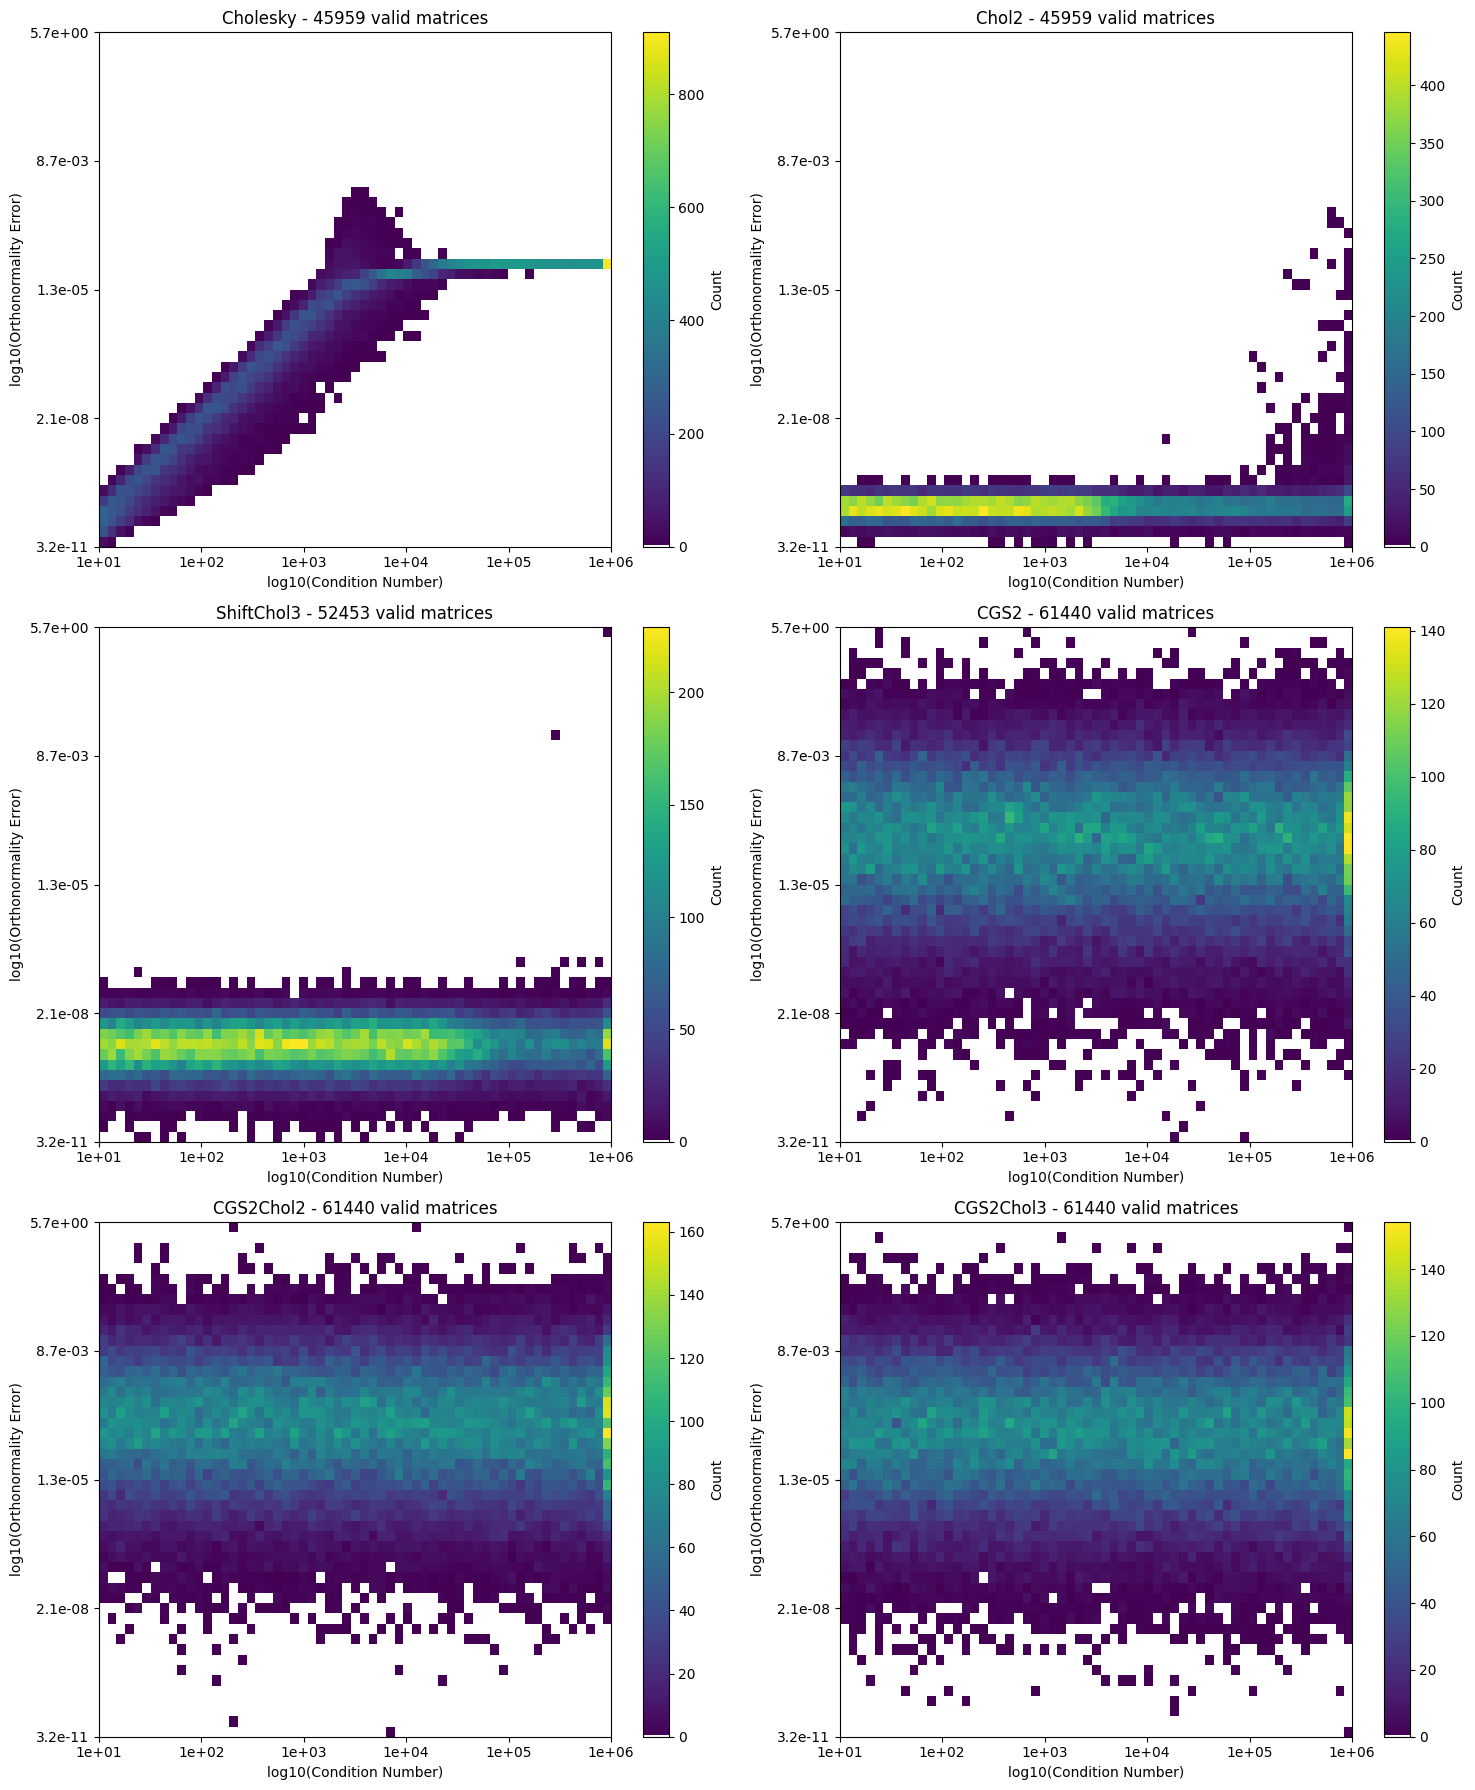

In [3]:
# Create 5 separate plots for the 2D histograms
fig, axs = plt.subplots(3, 2, figsize=(15, 18))
axs = axs.flatten()

# Create a custom colormap that starts with white for zero values
colors = [(1, 1, 1, 1)]  # Start with white (with alpha=1)
colors.extend(plt.cm.viridis(np.linspace(0, 1, 256)))  # Add viridis colors
white_viridis = LinearSegmentedColormap.from_list('white_viridis', colors, N=256)

# Determine shared y-axis range (log10 of orthonormality errors)
all_errors = np.concatenate([np.log10(np.array(results[name]['errors']) + 1e-16) for name in algorithm_names])
y_min, y_max = np.min(all_errors), np.max(all_errors)

# Adjust x-bins to match the explored condition number range
log_cond_min, log_cond_max = np.log10(condition_numbers[0]), np.log10(condition_numbers[-1])
x_bins = np.linspace(log_cond_min, log_cond_max, len(condition_numbers))

# Create heatmap for each algorithm
for idx, name in enumerate(algorithm_names):
    if idx >= len(axs):
        break
    
    conds = np.array(results[name]["cond_numbers"])
    errors = np.array(results[name]["errors"])
    
    if len(conds) == 0:
        axs[idx].text(0.5, 0.5, f"No valid results for {name}", 
                     horizontalalignment='center', verticalalignment='center')
        axs[idx].set_title(f"{name} - No valid matrices")
        continue
    
    # Create 2D histogram data
    log_conds = np.log10(conds)
    log_errors = np.log10(errors + 1e-16)
    
    heatmap_data, xedges, yedges = np.histogram2d(
        log_conds, log_errors, 
        bins=[x_bins, 50]  # Use adjusted x-bins and fixed y-bin count
    )
    
    # Plot the heatmap with white for zero values
    im = axs[idx].imshow(heatmap_data.T, origin='lower', aspect='auto',
                         extent=[log_cond_min, log_cond_max, y_min, y_max],
                         cmap=white_viridis)
    
    # Add colorbar
    cbar = fig.colorbar(im, ax=axs[idx])
    cbar.set_label('Count')
    
    # Set labels
    axs[idx].set_title(f"{name} - {len(conds)} valid matrices")
    axs[idx].set_xlabel("log10(Condition Number)")
    axs[idx].set_ylabel("log10(Orthonormality Error)")
    
    # Add tick labels as actual values
    x_ticks = np.linspace(log_cond_min, log_cond_max, 6)
    axs[idx].set_xticks(x_ticks)
    axs[idx].set_xticklabels([f"{10**x:.0e}" for x in x_ticks])
    
    y_ticks = np.linspace(y_min, y_max, 5)
    axs[idx].set_yticks(y_ticks)
    axs[idx].set_yticklabels([f"{10**y:.1e}" for y in y_ticks])

# Remove unused subplot
if len(algorithm_names) < len(axs):
    for i in range(len(algorithm_names), len(axs)):
        fig.delaxes(axs[i])

plt.tight_layout()
plt.show()